# Deskripsi
Proyek ini bertujuan untuk memprediksi perubahan persentase harga saham harian menggunakan data historis. Algoritma yang digunakan adalah Linear Regression untuk menganalisis hubungan antara fitur saham utama dengan variabel target

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


Mengimpor pustaka pandas untuk manipulasi dan analisis data dalam bentuk tabel.

Mengimpor matplotlib.pyplot untuk membuat visualisasi data seperti grafik.

Mengimpor seaborn untuk visualisasi data statistik dengan gaya yang estetis.

Mengimpor model perataan eksponensial sederhana dari Statsmodels untuk analisis deret waktu.

Mengimpor model perataan eksponensial lanjutan untuk deret waktu dengan tren dan musiman.

Mengimpor model ARIMA dari Statsmodels untuk analisis dan prediksi data deret waktu.

Mengimpor fungsi untuk membagi data menjadi set pelatihan dan pengujian.

Mengimpor model regresi linear dari scikit-learn untuk membuat prediksi.

Mengimpor metrik untuk menghitung galat kuadrat rata-rata (MSE) sebagai evaluasi model.

In [2]:
# Gantilah 'nama_file.xlsx' dengan nama file dataset yang Anda miliki
df = pd.read_excel('Copy of brentcrudeoil.xlsx')


In [3]:
print (df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        761 non-null    datetime64[ns]
 1   Close       761 non-null    float64       
 2   chg(close)  761 non-null    float64       
 3   Low         761 non-null    float64       
 4   chg(low)    761 non-null    float64       
 5   High        761 non-null    float64       
 6   chg(high)   761 non-null    float64       
 7   Unnamed: 7  0 non-null      float64       
 8   Unnamed: 8  0 non-null      float64       
 9   Unnamed: 9  1 non-null      object        
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 59.6+ KB
None


In [4]:
print(df.head())

                     Date  Close  chg(close)    Low  chg(low)   High  \
0 2021-01-04 23:57:59.904  50.23       50.23  49.97     49.97  51.88   
1 2021-01-05 23:57:59.904  51.87        1.64  50.01      0.04  52.26   
2 2021-01-06 23:57:59.904  52.02        0.15  51.21      1.20  52.37   
3 2021-01-07 23:57:59.904  52.20        0.18  51.89      0.68  52.34   
4 2021-01-08 23:57:59.904  53.33        1.13  52.31      0.42  53.61   

   chg(high)  Unnamed: 7  Unnamed: 8 Unnamed: 9  
0      51.88         NaN         NaN             
1       0.38         NaN         NaN        NaN  
2       0.11         NaN         NaN        NaN  
3      -0.03         NaN         NaN        NaN  
4       1.27         NaN         NaN        NaN  


In [5]:
print(df.describe())

                                Date       Close  chg(close)         Low  \
count                            761  761.000000  761.000000  761.000000   
mean   2022-07-08 20:20:42.954638336   80.299829    0.101919   79.178029   
min       2021-01-04 23:57:59.904000   50.230000  -17.140000   49.970000   
25%       2021-10-05 23:57:59.904000   72.460000   -0.790000   71.540000   
50%       2022-07-08 23:57:59.904000   79.810000    0.210000   78.750000   
75%       2023-04-11 23:57:59.904000   88.150000    1.080000   87.220000   
max       2024-01-12 23:57:59.904000  114.190000   50.230000  113.390000   
std                              NaN   12.308584    2.717944   12.036615   

         chg(low)        High   chg(high)  Unnamed: 7  Unnamed: 8  
count  761.000000  761.000000  761.000000         0.0         0.0  
mean     0.101629   81.365204    0.104179         NaN         NaN  
min    -13.990000   51.880000  -18.050000         NaN         NaN  
25%     -0.680000   73.600000   -0.570000  

In [6]:
df = df.drop(['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'], axis=1)


Pada output df.describe(), kita melihat ringkasan statistik dari data numerik dalam DataFrame. Kolom seperti Close, chg(close), Low, dan High memiliki data yang lengkap dengan rata-rata dan distribusi yang jelas, seperti rata-rata harga Close sebesar 80.3 dan perubahan harga harian rata-rata sebesar 0.1%. Namun, ada kolom kosong, yaitu Unnamed: 7, Unnamed: 8, dan Unnamed: 9, yang tidak memiliki data sama sekali. Untuk itu, kolom-kolom kosong ini dihapus menggunakan perintah df.drop() agar hanya kolom yang relevan dan bernilai digunakan dalam analisis berikutnya.

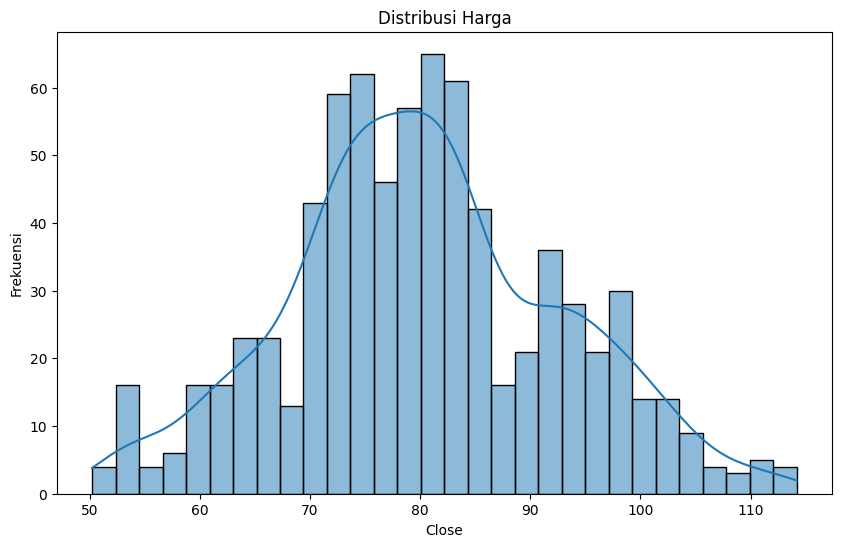

In [7]:
plt.figure(figsize=(10,6))
sns.histplot(df['Close'],bins=30,kde=True)
plt.title('Distribusi Harga')
plt.xlabel('Close')
plt.ylabel('Frekuensi')
plt.show()

1. Histogram menunjukkan distribusi harga Close yang mendekati normal, dengan puncak di sekitar 80.
2. Mayoritas harga berkisar antara 70 hingga 90, menjadi rentang yang paling sering muncul.
3. Terdapat sedikit skew ke kanan, menunjukkan beberapa harga tinggi di atas rata-rata.
4. Data ekstrem terlihat di bawah 60 dan di atas 110, meskipun jumlahnya sangat kecil.

In [8]:
# Menyusun data time series
time_series = df[['Date', 'Close']].set_index('Date')['Close']


In [9]:
# Membagi data menjadi set pelatihan dan pengujian (80% pelatihan, 20% pengujian)
train_size = int(len(time_series) * 0.8)
train, test = time_series[:train_size], time_series[train_size:]

In [10]:
# Fungsi untuk mengevaluasi dan plot hasil prediksi
def evaluate_and_plot(predictions, test, method):
    mse = ((predictions - test) ** 2).mean()
    print(f'Mean Squared Error ({method}): {mse}')
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train, label='Training Data')
    plt.plot(test.index, test, label='Test Data')
    plt.plot(predictions.index, predictions, label=f'{method} Predictions', linestyle='dashed')
    plt.legend()
    plt.title(f'{method} Predictions vs Actual')
    plt.show()

Fungsi evaluate_and_plot ini digunakan untuk mengevaluasi performa model dengan menghitung nilai Mean Squared Error atau MSE, yang langsung dicetak sebagai hasil evaluasi. Selain itu, fungsi ini juga membuat grafik perbandingan antara data pelatihan, data uji, dan hasil prediksi, sehingga memudahkan kita untuk melihat bagaimana model bekerja secara visual. Grafik ini dilengkapi dengan legenda dan judul, jadi hasilnya lebih mudah dipahami

Mean Squared Error (Moving Average): 2.3432959477124196


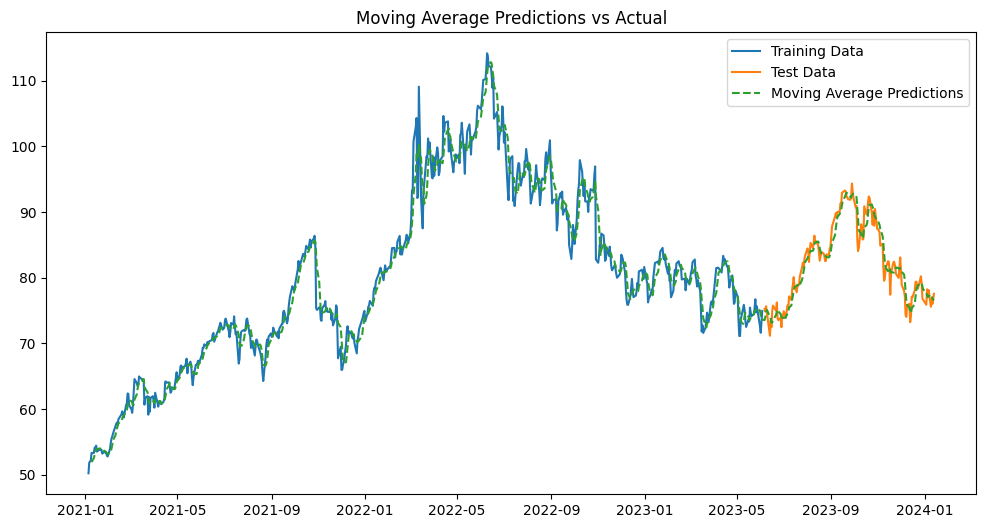

In [11]:
window_size = 5
moving_avg = time_series.rolling(window=window_size).mean().dropna()
evaluate_and_plot(moving_avg, test, 'Moving Average')

c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Mean Squared Error (Exponential Smoothing): 56.72924188196226


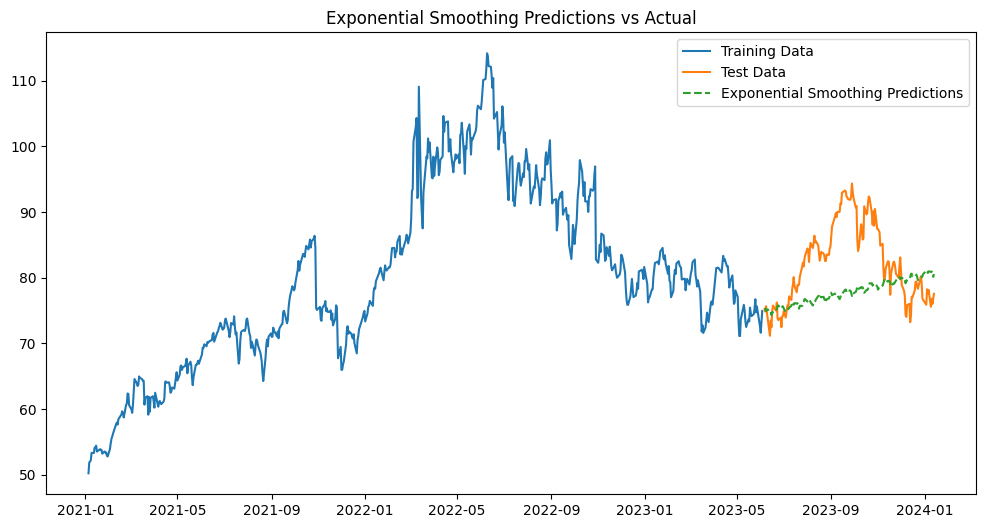

In [12]:
# Metode Exponential Smoothing
exp_smooth = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()
exp_smooth_predictions = exp_smooth.forecast(len(test))
exp_smooth_predictions.index = test.index  # Sesuaikan indeks
evaluate_and_plot(exp_smooth_predictions, test, 'Exponential Smoothing')


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Predicti

Mean Squared Error (ARIMA): 98.82789158685607


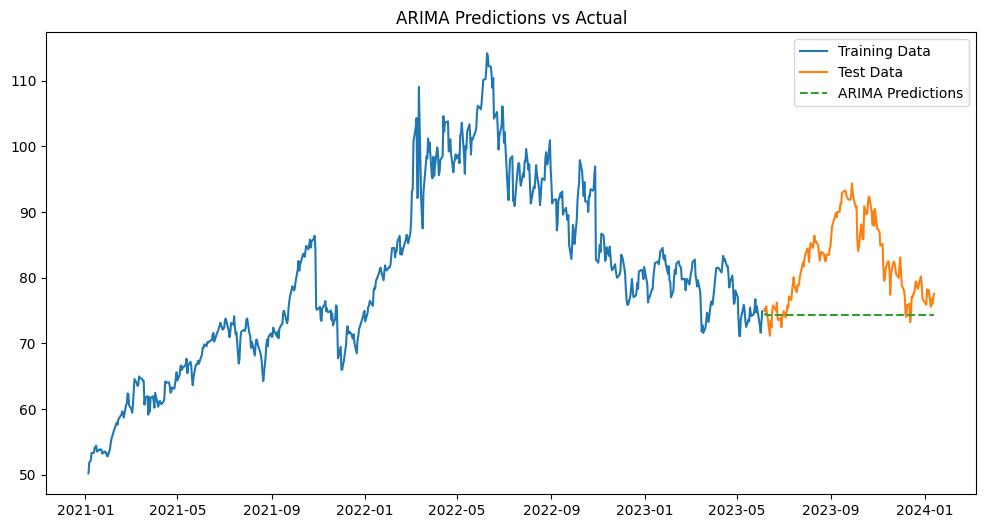

In [13]:
# Metode ARIMA
arima_model = ARIMA(train, order=(5, 1, 0)).fit()
arima_predictions = arima_model.forecast(steps=len(test))
arima_predictions.index = test.index  # Sesuaikan indeks
evaluate_and_plot(arima_predictions, test, 'ARIMA')

Grafik ini menunjukkan perbandingan antara data pelatihan (biru), data uji (oranye), dan prediksi ARIMA (hijau putus-putus). Dari data uji, terlihat harga saham bergerak antara 70 hingga 90, sementara model ARIMA memberikan prediksi yang lebih stabil di sekitar rata-rata, yaitu sekitar 80. Meski prediksi mendekati rata-rata, model ARIMA kurang mampu menangkap fluktuasi yang lebih tajam pada data uji, seperti kenaikan atau penurunan mendadak

In [14]:
# Pisahkan data menjadi train dan test
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:]

In [15]:
# Pilih fitur dan target
features = ['Close', 'Low', 'High']
target = 'chg(close)'


In [16]:
# Pisahkan data menjadi fitur (X) dan target (y)
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

In [17]:
# Inisialisasi model Regresi Linear
model = LinearRegression()

In [18]:
# Latih model
model.fit(X_train, y_train)

LinearRegression()

In [19]:
# Lakukan prediksi
predictions = model.predict(X_test)

In [20]:
# Evaluasi hasil dengan Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (Linear Regression): {mse}")

Mean Squared Error (Linear Regression): 0.5678387397864099


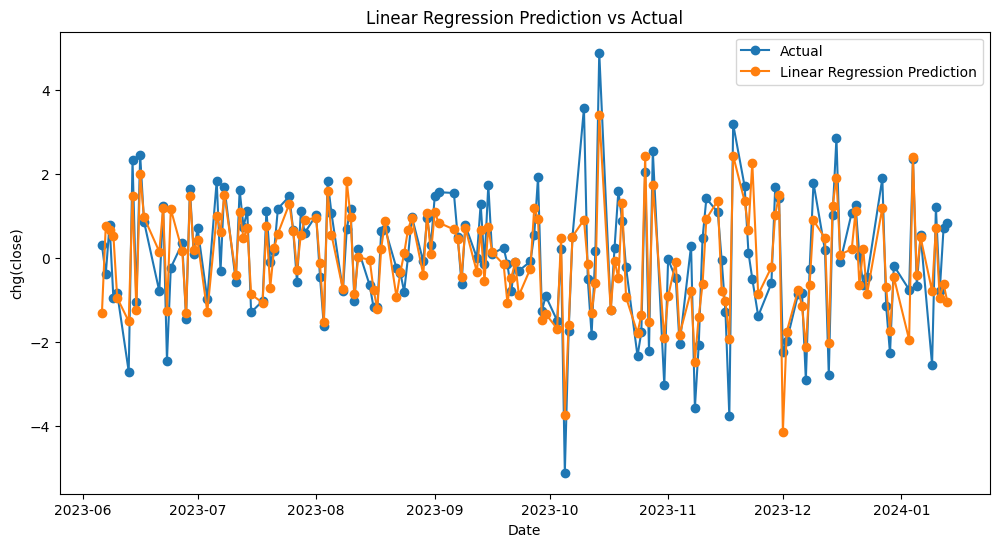

In [21]:
# Plot hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(test['Date'], y_test, label='Actual', marker='o')
plt.plot(test['Date'], predictions, label='Linear Regression Prediction', marker='o')
plt.title('Linear Regression Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('chg(close)')
plt.legend()
plt.show()


# Interpretasi Akhir Grafik Linear Regression Prediction vs Actual

**Keselarasan Pola**

Model regresi linear cukup baik dalam mengikuti pola perubahan harga aktual, terutama pada perubahan yang tidak terlalu tajam.

**Deviasi pada Fluktuasi Ekstrem**

Model mengalami deviasi yang signifikan pada lonjakan besar, seperti yang terlihat pada Oktober 2023.

**Kesesuaian dengan Tren Stabil**

Model lebih efektif untuk memprediksi data dengan pola perubahan yang stabil dibandingkan data yang sangat fluktuatif.

**Kesimpulan Umum**

Regresi linear memiliki performa yang layak, tetapi dapat ditingkatkan lebih lanjut untuk menangkap fluktuasi ekstrem.